<a href="https://colab.research.google.com/github/tancik/fourier-feature-networks/blob/master/Experiments/kernel_spreading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://www.github.com/google/neural-tangents

In [ ]:
import jax.numpy as np
import numpy as onp

from jax.experimental import optimizers
from jax.api import jit, grad, vmap

import functools

import neural_tangents as nt
from neural_tangents import stax

%matplotlib inline
import matplotlib


import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.lines import Line2D

In [ ]:
RES = 128
mres = np.log2(RES//2)

embedding_size = 256

enc_dict = {}

input_encoder = lambda x, a, b: np.concatenate([a * np.sin((2.*np.pi*x) @ b.T), 
                                                a * np.cos((2.*np.pi*x) @ b.T)], axis=-1) / np.linalg.norm(a) * np.sqrt(a.shape[0])

# Basic
bvals = np.ones((1,1))
avals = np.ones((bvals.shape[0])) 
enc_dict['basic'] = (avals, bvals)

# PosEnc Gap
bvals = np.array([1]+([0]*int(mres-2))+[RES//3+1])[:,None]
print(bvals)
avals = np.ones((bvals.shape[0])) 
enc_dict['posenc_gap'] = (avals, bvals)

def make_net(width, depth):
  stax_args = []
  for i in range(depth):
    stax_args = stax_args + [stax.Dense(width), stax.Relu()]
  stax_args.append(stax.Dense(1))
  return stax.serial(*stax_args)

init_fn, apply_fn, kernel_fn = make_net(512,2)

def compute_ntk(k,width, depth):
    init_fn, apply_fn, kernel_fn = make_net(512,depth)

    x1 = np.linspace(0,1,RES,endpoint=False)[:,None]
    x2 = np.array([.5]).reshape((1,1))
    x1 = input_encoder(x1,*enc_dict[k])
    x2 = input_encoder(x2,*enc_dict[k])
    if k == 'basic':
      x1 = np.concatenate([x1, np.zeros((x1.shape[0], int(mres*2-x1.shape[1])))],axis=-1)
      x2 = np.concatenate([x2, np.zeros((x2.shape[0], int(mres*2-x2.shape[1])))],axis=-1)
    
    kernel = kernel_fn(x1, x2, 'ntk')
    return kernel

def make_plot(k, depths, width=512):
  ntk_kernels = [compute_ntk(k, width, d) for d in depths]
  
  to_plot_lst = []
  for kernel,d in zip(ntk_kernels, depths):
    to_plot = np.abs(np.fft.fftshift(onp.fft.fft(kernel[:,0], norm='ortho')))
    to_plot = to_plot/kernel[0,0]
    to_plot_lst.append(to_plot)
  return to_plot_lst

[[ 1]
 [ 0]
 [ 0]
 [ 0]
 [ 0]
 [43]]


/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5487: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


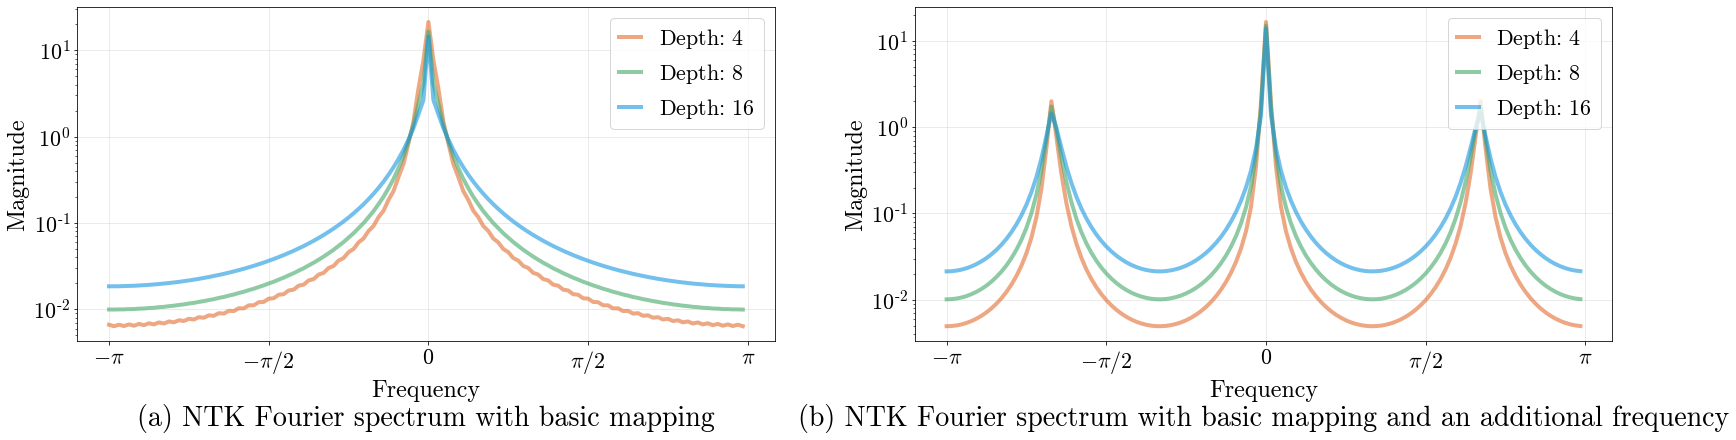

In [ ]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

params = {'legend.fontsize': 22,
         'axes.labelsize': 24,
         'axes.titlesize': 28,
         'xtick.labelsize':22,
         'ytick.labelsize':22}
pylab.rcParams.update(params)


matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['mathtext.rm'] = 'serif'

plt.rcParams["font.family"] = "cmr10"

N_fams = 3



colors_k = np.array([[0.8872, 0.4281, 0.1875],
    # [0.8136, 0.6844, 0.0696],
    [0.2634, 0.6634, 0.4134],
    [0.0943, 0.5937, 0.8793],
    [0.3936, 0.2946, 0.6330],
    [0.7123, 0.2705, 0.3795]])

linewidth = 4
legend_offset = -.27



basic_plots = make_plot('basic', [4,8,16])
posenc_gap_plots = make_plot('posenc_gap', [4,8,16])



fig3 = plt.figure(constrained_layout=True, figsize=(24,6))
gs = fig3.add_gridspec(1,2)

ax = fig3.add_subplot(gs[0,0])

for c, d, plot in zip(colors_k[:3], [4,8,16], basic_plots):
  plt.semilogy(plot, color=c, label='Depth: ${}$'.format(d), linewidth=linewidth, linestyle='-', alpha=.6)

ax.set_title('(a) NTK Fourier spectrum with basic mapping', y=legend_offset)
plt.xticks([0,32,64,96,128], ['$-\pi$','$-\pi/2$','$0$','$\pi/2$','$\pi$'])

ax.legend(loc='upper right', handlelength=1)
plt.xlabel('Frequency')
plt.ylabel(r'Magnitude')
plt.grid(True, which='major', alpha=.3)


ax = fig3.add_subplot(gs[0,1:])

for c, d, plot in zip(colors_k[:3], [4,8,16], posenc_gap_plots):
  plt.semilogy(plot, color=c, label='Depth: ${}$'.format(d), linewidth=linewidth, linestyle='-', alpha=.6)


ax.set_title('(b) NTK Fourier spectrum with basic mapping and an additional frequency', y=legend_offset)
plt.xticks([0,32,64,96,128], ['$-\pi$','$-\pi/2$','$0$','$\pi/2$','$\pi$'])

ax.legend(loc='upper right', handlelength=1)
plt.xlabel('Frequency')
plt.ylabel(r'Magnitude')
plt.grid(True, which='major', alpha=.3)

plt.savefig('spreading_supp.pdf', bbox_inches='tight', pad_inches=0)
